In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import sys
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [2]:
def printdf(df, round=2):
    with io.StringIO() as buffer:
        df.round(round).to_csv(buffer, sep=' ', index=False)
        print(buffer.getvalue())

# SEQKIT Summary

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/scpc_test/reports/seqkit/raw.fastq.report.txt"

pdf = pd.read_csv(fpath, sep=r"\s+")
pdf['sample'] = pdf['file'].apply(lambda x: x[:2])
pdf['cell'] = pdf['file'].apply(lambda x: x[2:5])

PCRmap = {
    'o1' : 35,
    'o2' : 25,
    'o3' : 25,
}

columns = [
    'num_seqs',
    'sum_len',
    'min_len',
    'avg_len',
    'max_len',
    'Q1',
    'Q2',
    'Q3',
    'N50',
] 

for c in columns:
    pdf[c] = pdf[c].astype(str).str.replace(',', '').astype(float)


keep_cols = [
    'sample', 
    'cell',
    'num_seqs', 
    'sum_len', 
    'min_len',
    'avg_len',
    'max_len', 
    'N50', 
    'AvgQual', 
    'GC(%)', 
]

pdf = pdf[keep_cols]
pdf.columns = [
    'Sample', 
    'Barcode', 
    'Reads', 
    'Bases (Gb)',
    'Min Read Length',
    'Mean Read Length',
    'Max Read Length', 
    'N50',
    'Mean Base Quality',
    'GC (%)',
]

### Translate bases into Gb
pdf['Bases (Gb)'] = pdf['Bases (Gb)'] / 1e9
pdf['PCR Cycles'] = pdf['Sample'].map(PCRmap)
    
print(f"{pdf.shape=}")
pdf.head()

pdf.shape=(284, 11)


,Sample,Barcode,Reads,Bases (Gb),Min Read Length,Mean Read Length,Max Read Length,N50,Mean Base Quality,GC (%),PCR Cycles
0,o1,b01,2167.0,0.001612,143.0,743.8,6461.0,900.0,14.65,43.87,35
1,o1,b02,175454.0,0.230069,39.0,1311.3,10334.0,1540.0,14.11,42.68,35
2,o1,b03,275079.0,0.352372,38.0,1281.0,9811.0,1442.0,13.85,43.17,35
3,o1,b04,292913.0,0.398704,38.0,1361.2,109782.0,1503.0,13.97,42.74,35
4,o1,b05,431363.0,0.580784,36.0,1346.4,11053.0,1552.0,14.07,42.52,35


# Write to file

In [4]:
# generate the summary
gx = pdf.groupby(['Sample', 'PCR Cycles']).agg(
    Total_Cells = ('Barcode', 'nunique'),
    Total_Reads = ('Reads', 'sum'),
    Mean_Reads = ('Reads', 'mean'),
    Total_Bases_Gb = ('Bases (Gb)', 'sum'),
    Mean_Bases_Gb = ('Bases (Gb)', 'mean'),
    Mean_Read_Length = ('Mean Read Length', 'mean'),
    Mean_N50 = ('N50', 'mean'),
    Mean_Base_Quality = ('Mean Base Quality', 'mean'),
    Mean_GC = ('GC (%)', 'mean'),
).reset_index().round(3)


outpath = "/scratch/indikar_root/indikar1/cstansbu/scpc_test/analysis/excel_reports/basecall_summary.xlsx"
with pd.ExcelWriter(outpath, engine='xlsxwriter') as writer:
    # summary as the first tab
    gx.to_excel(writer, sheet_name='Basecall_Summary', index=False)

    # save each sample to a new tab
    for sample, group in pdf.groupby('Sample'):
        group.to_excel(writer, sheet_name=f"Basecall_Summary_{sample}", index=False)

print(f'saved: {outpath}')

saved: /scratch/indikar_root/indikar1/cstansbu/scpc_test/analysis/excel_reports/basecall_summary.xlsx


# Histograms

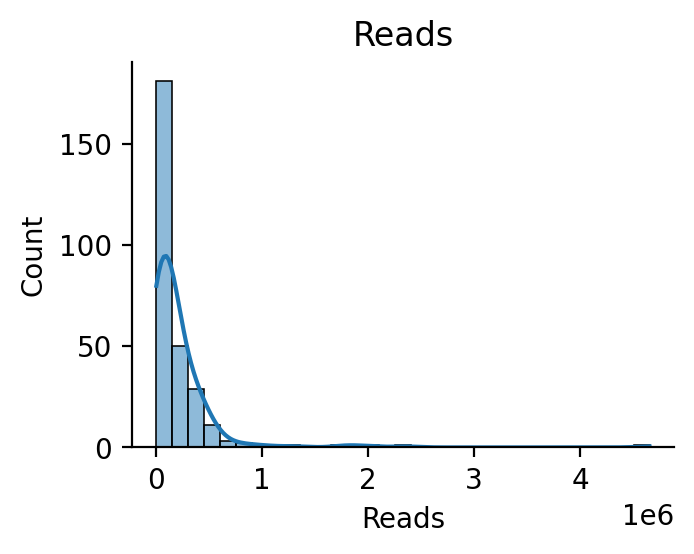

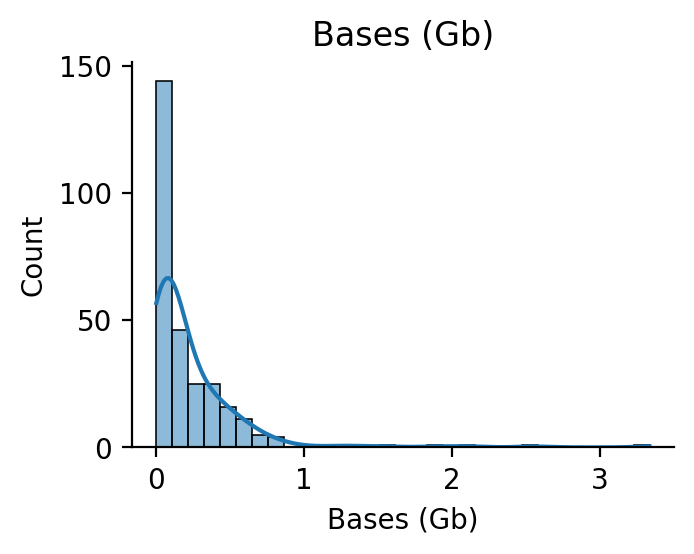

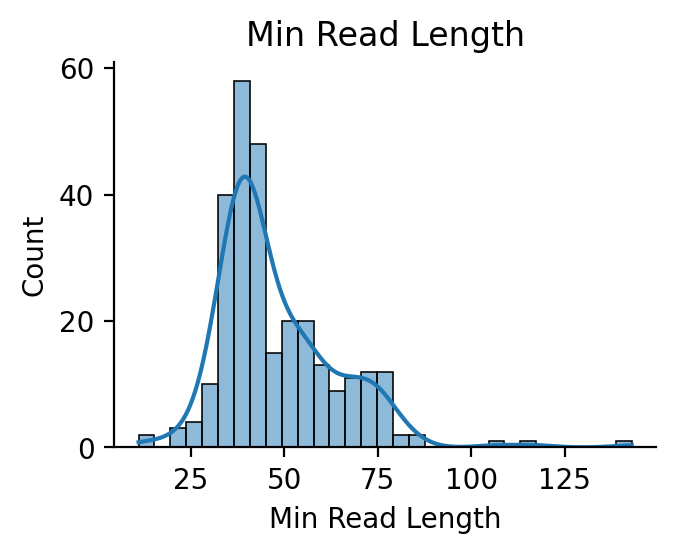

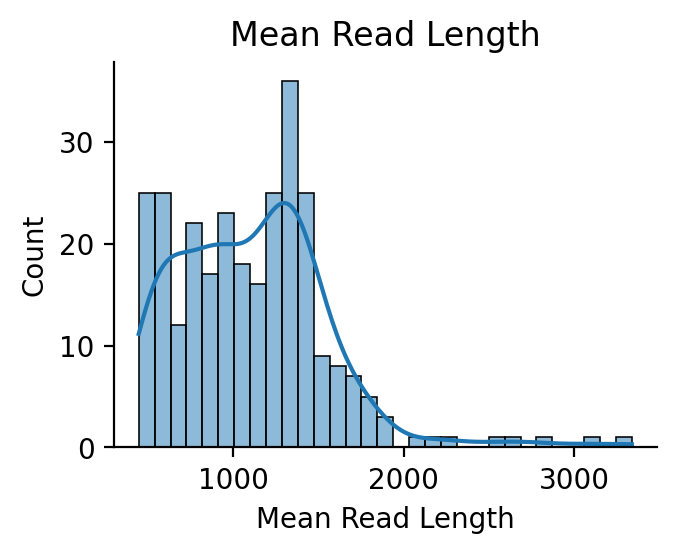

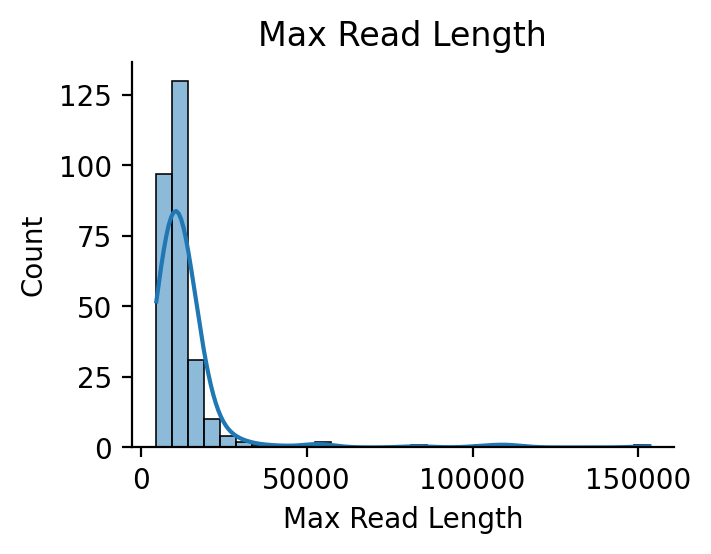

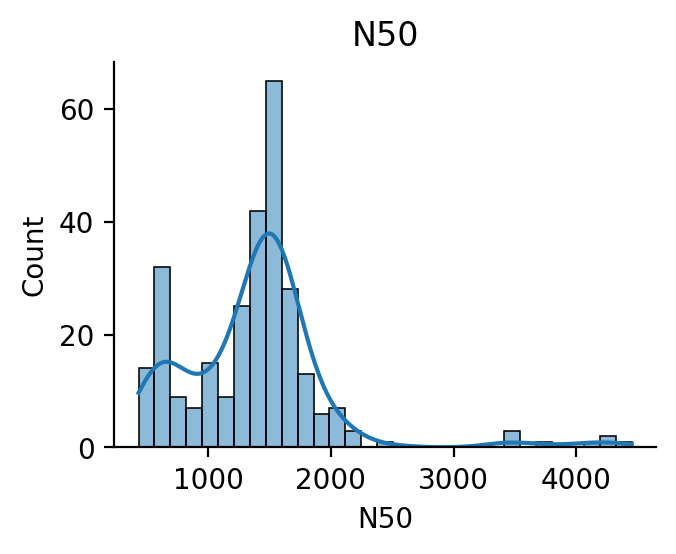

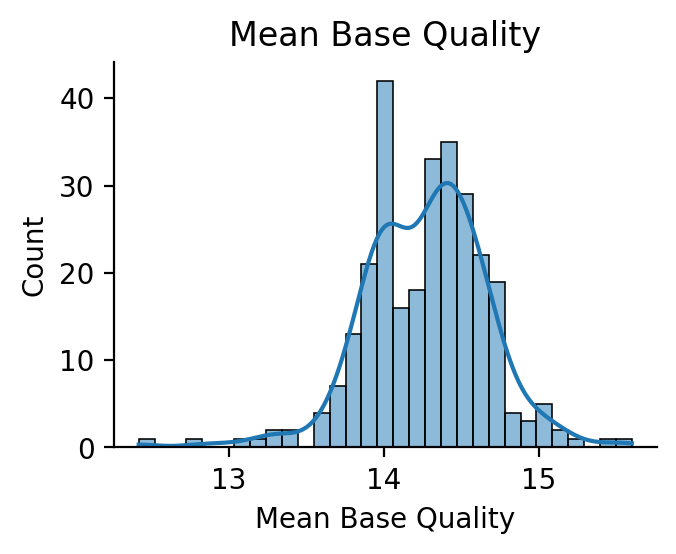

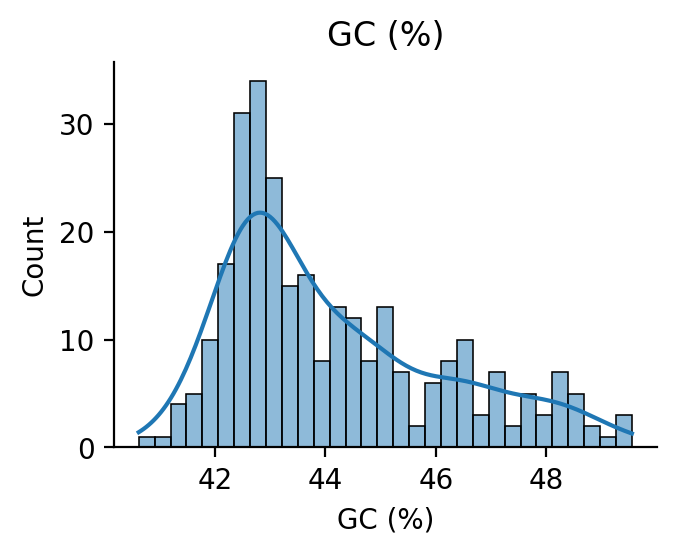

In [5]:
plot_cols = [
    'Reads', 
    'Bases (Gb)',
    'Min Read Length',
    'Mean Read Length',
    'Max Read Length', 
    'N50',
    'Mean Base Quality',
    'GC (%)',    
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2.5

for c in plot_cols:
    sns.histplot(data=pdf, 
                 x=c,
                 bins=31,
                 kde=True)

    plt.title(c)
    sns.despine()
    plt.show()

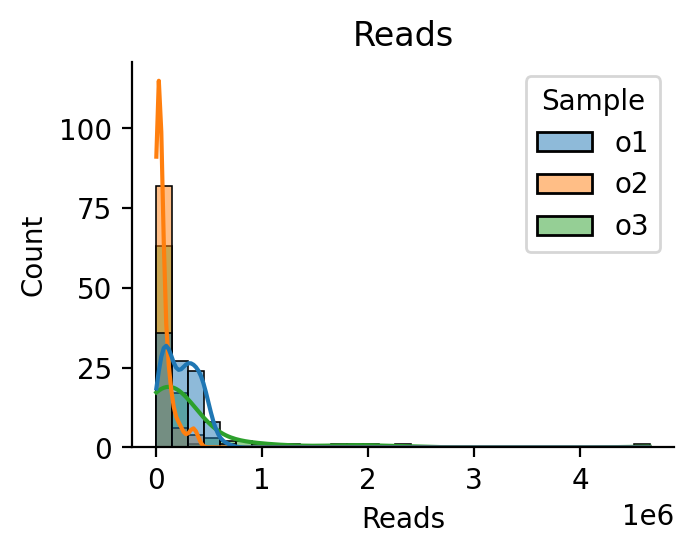

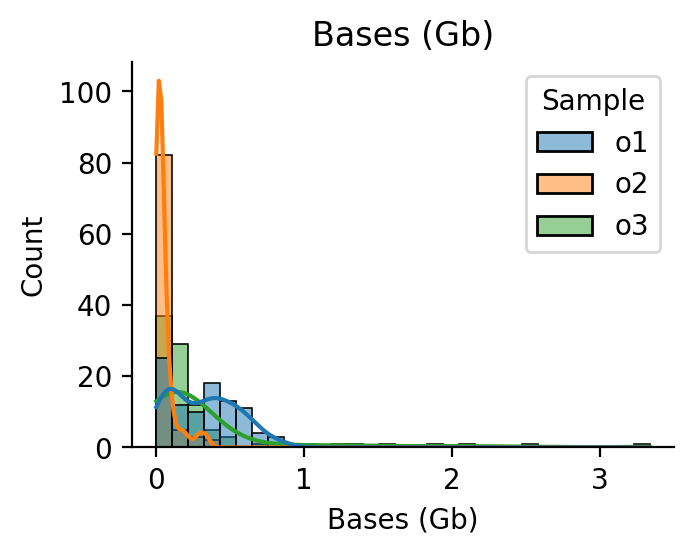

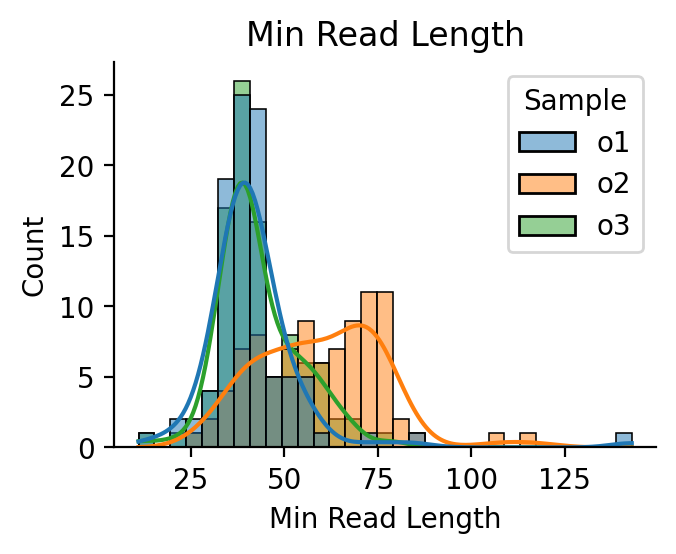

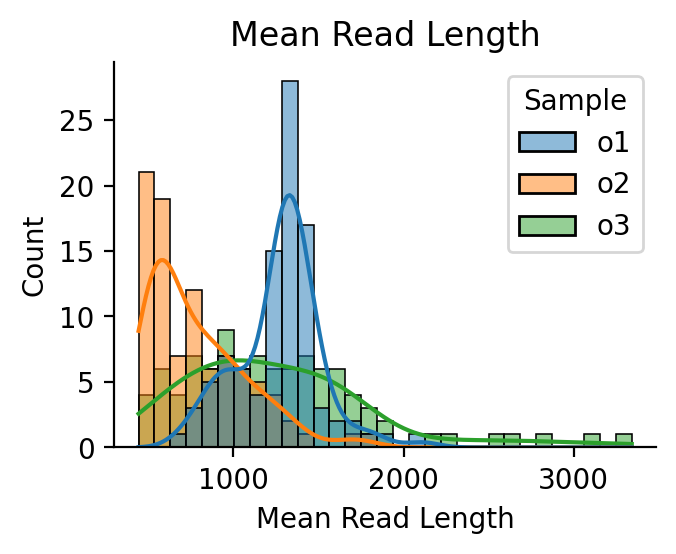

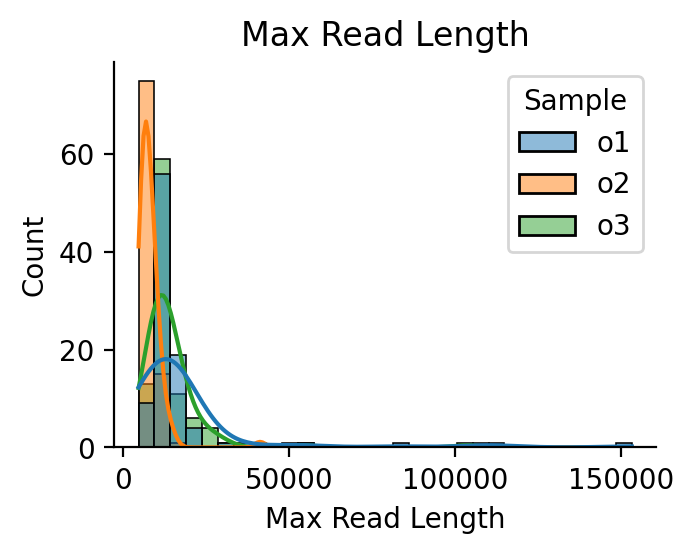

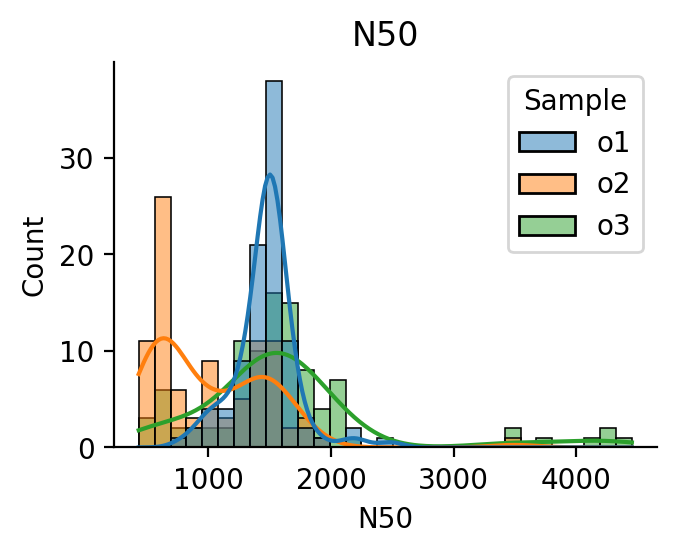

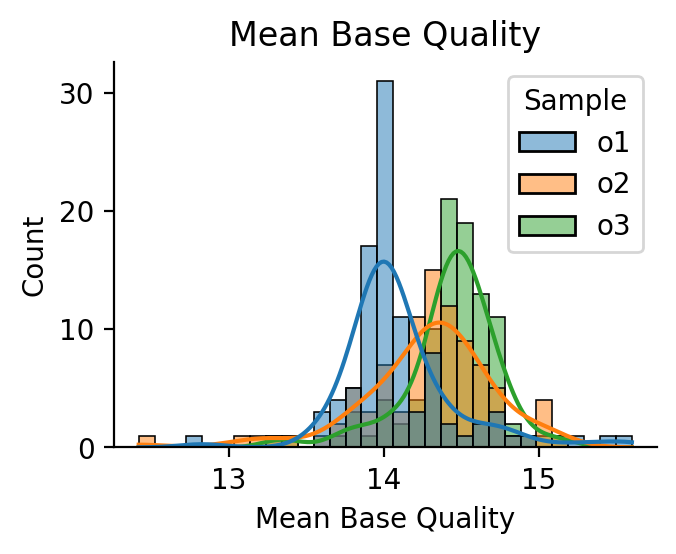

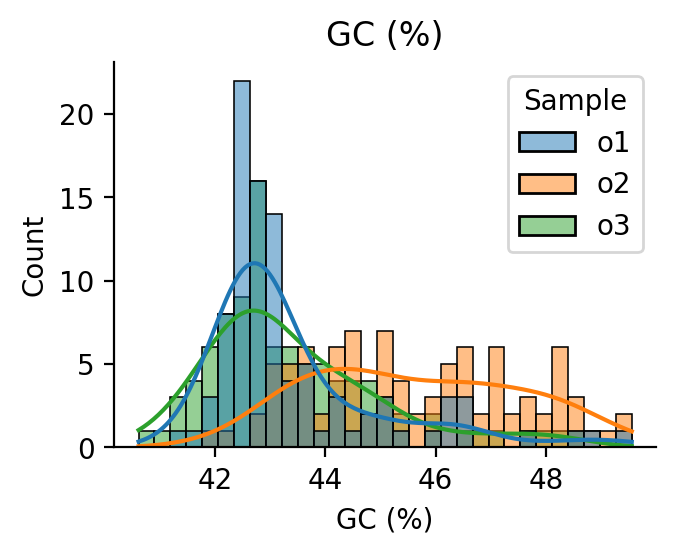

In [7]:
plot_cols = [
    'Reads', 
    'Bases (Gb)',
    'Min Read Length',
    'Mean Read Length',
    'Max Read Length', 
    'N50',
    'Mean Base Quality',
    'GC (%)',    
]

pdf = pdf.sort_values(by=['Sample', 'Barcode'])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2.5

for c in plot_cols:
    sns.histplot(data=pdf, 
                 x=c,
                 hue='Sample',
                 bins=31,
                 kde=True)

    plt.title(c)
    sns.despine()
    plt.show()

# Scatterplots 

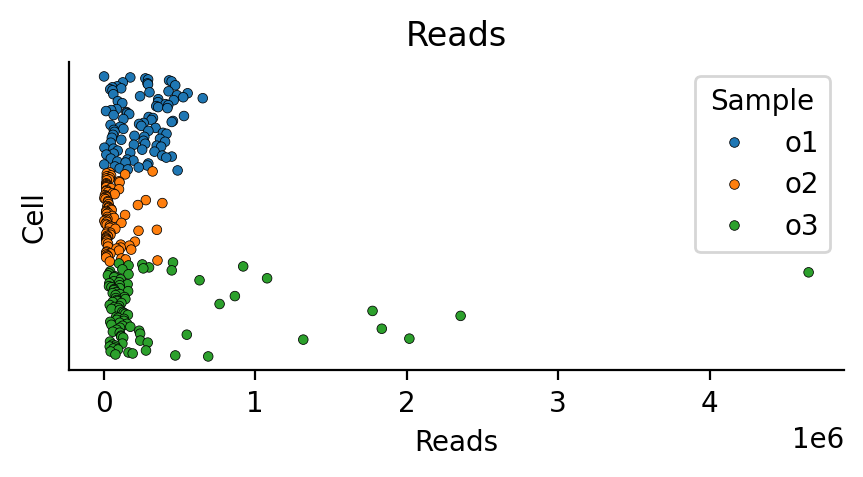

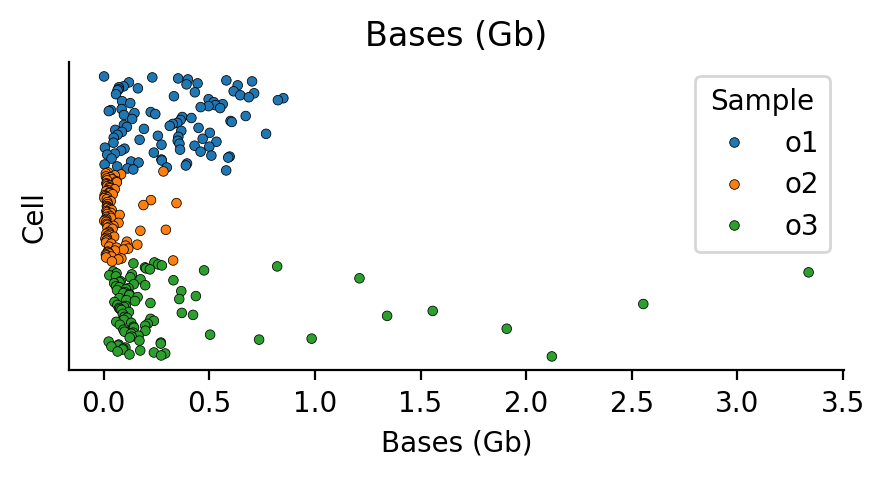

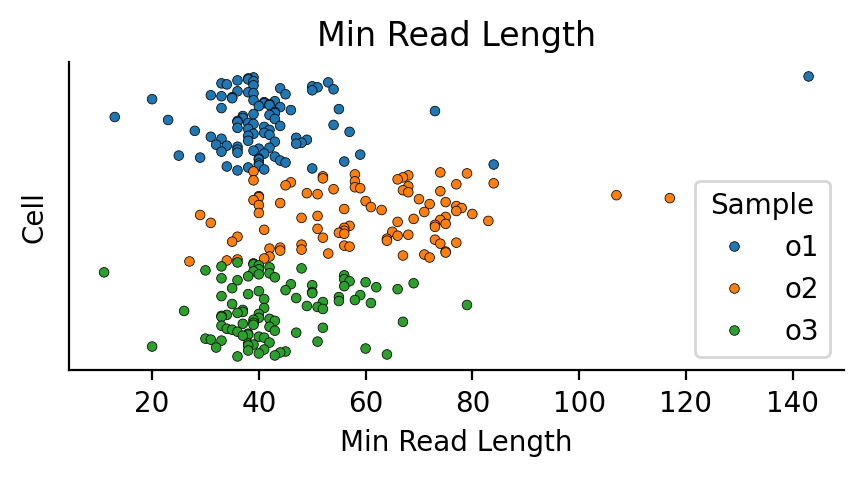

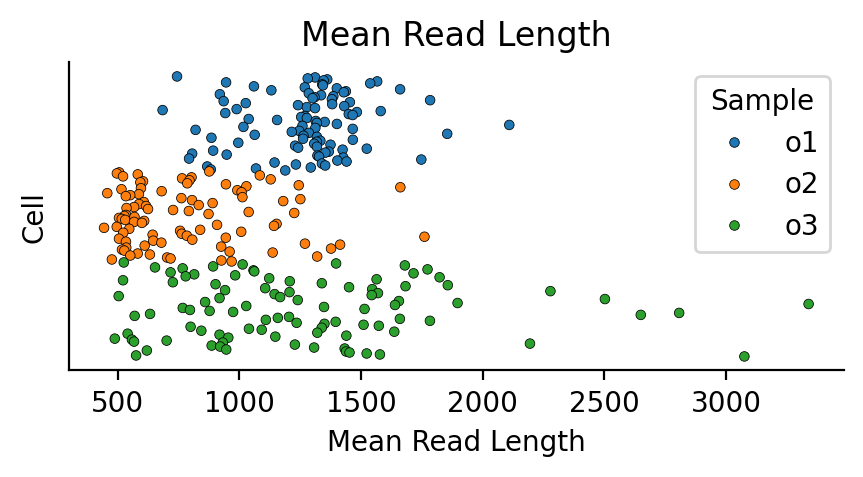

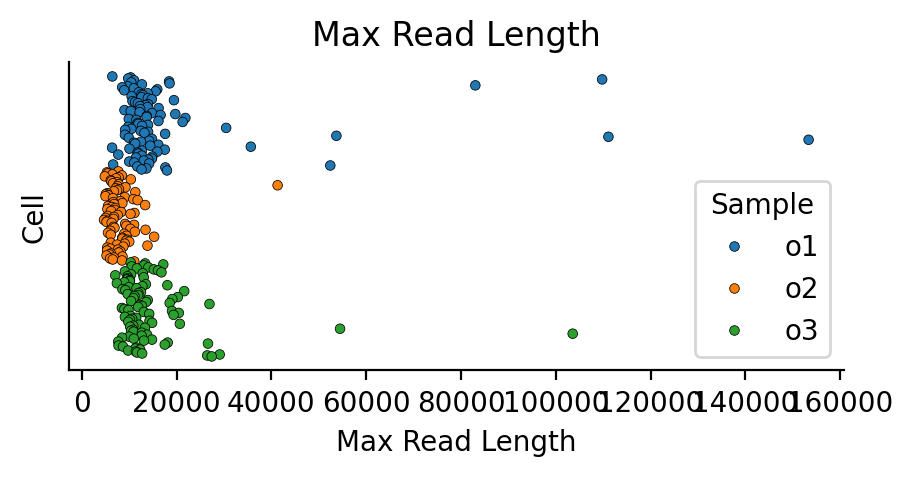

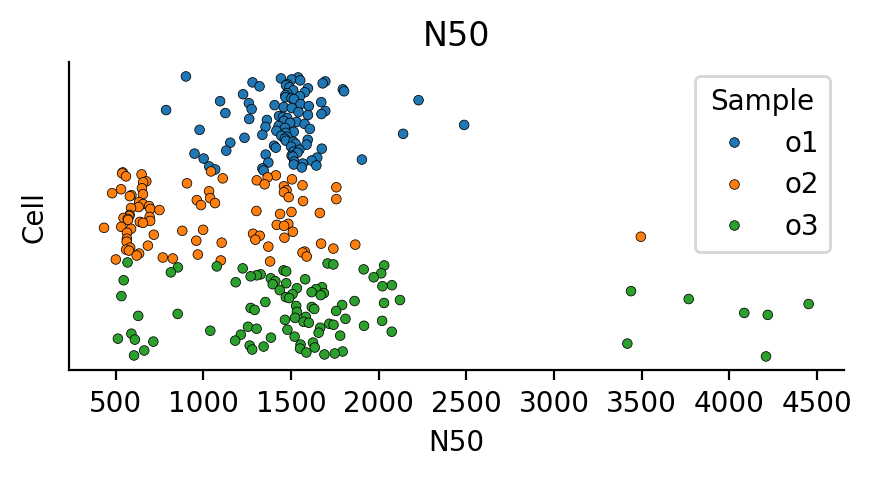

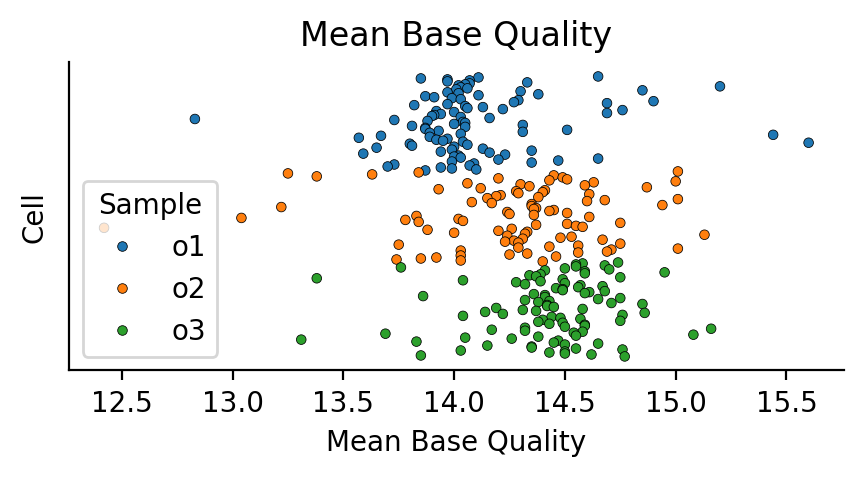

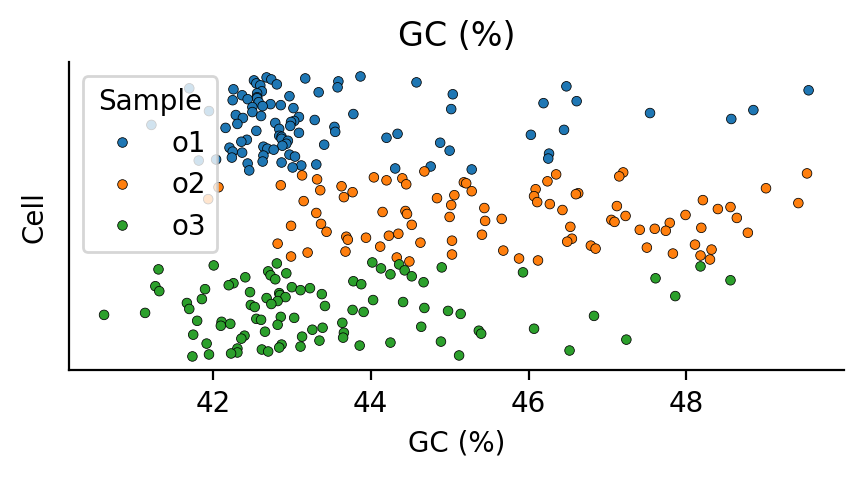

In [9]:
plot_cols = [
    'Reads', 
    'Bases (Gb)',
    'Min Read Length',
    'Mean Read Length',
    'Max Read Length', 
    'N50',
    'Mean Base Quality',
    'GC (%)',    
]

pdf = pdf.sort_values(by=['Sample', 'Barcode'])

# add the index 
pdf['index'] = list(range(len(pdf)))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2


for c in plot_cols:
    sns.scatterplot(data=pdf,
                    y="index",
                    x=c,
                    ec='k',
                    s=12,
                    hue='Sample')

    plt.title(c)
    ax = plt.gca()
    _ = ax.set_yticklabels([])
    _ = ax.set_yticks([])
    ax.invert_yaxis()
    plt.ylabel("Cell")
    sns.despine()
    plt.show()

# Specific Analysis

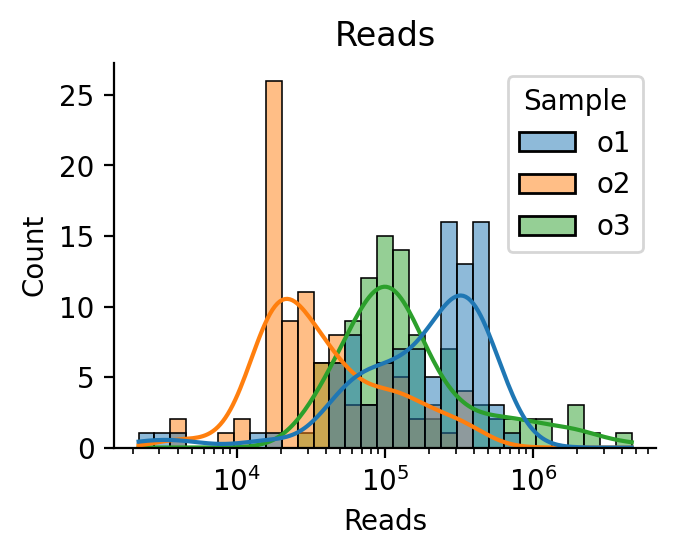

In [27]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2.5

sns.histplot(data=pdf, 
             x='Reads',
             hue='Sample',
             bins=31,
             log_scale=True,
             kde=True)

plt.title('Reads')
sns.despine()
plt.show()

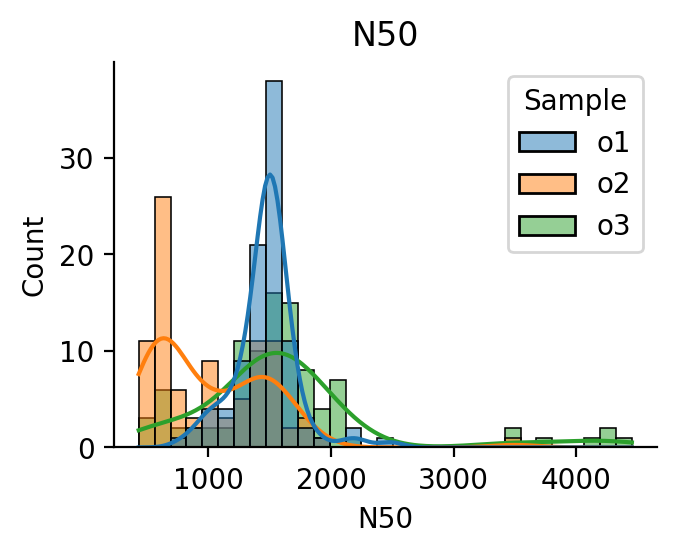

In [40]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2.5

sns.histplot(data=pdf, 
             x='N50',
             hue='Sample',
             bins=31,
             kde=True)

plt.title('N50')
sns.despine()
plt.show()

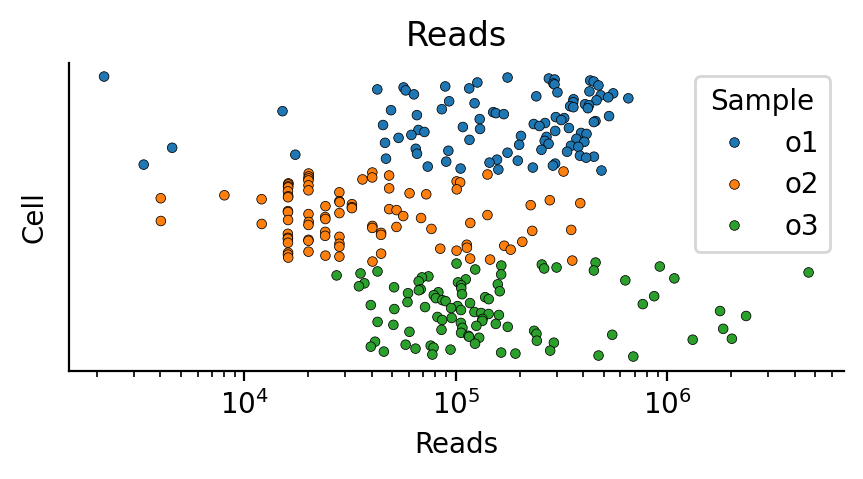

In [12]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2

sns.scatterplot(data=pdf,
                y="index",
                x='Reads',
                ec='k',
                s=12,
                hue='Sample')

plt.title('Reads')
plt.xscale('log')
ax = plt.gca()
_ = ax.set_yticklabels([])
_ = ax.set_yticks([])
ax.invert_yaxis()
plt.ylabel("Cell")
sns.despine()
plt.show()

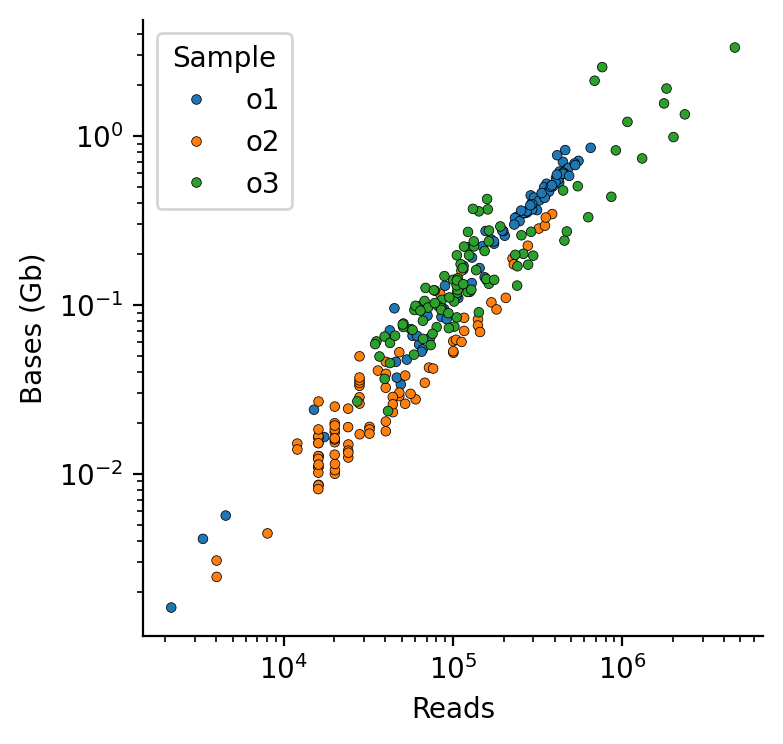

In [25]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=pdf,
                y="Bases (Gb)",
                x='Reads',
                ec='k',
                s=12,
                hue='Sample')

plt.xscale('log')
plt.yscale('log')
sns.despine()
plt.show()

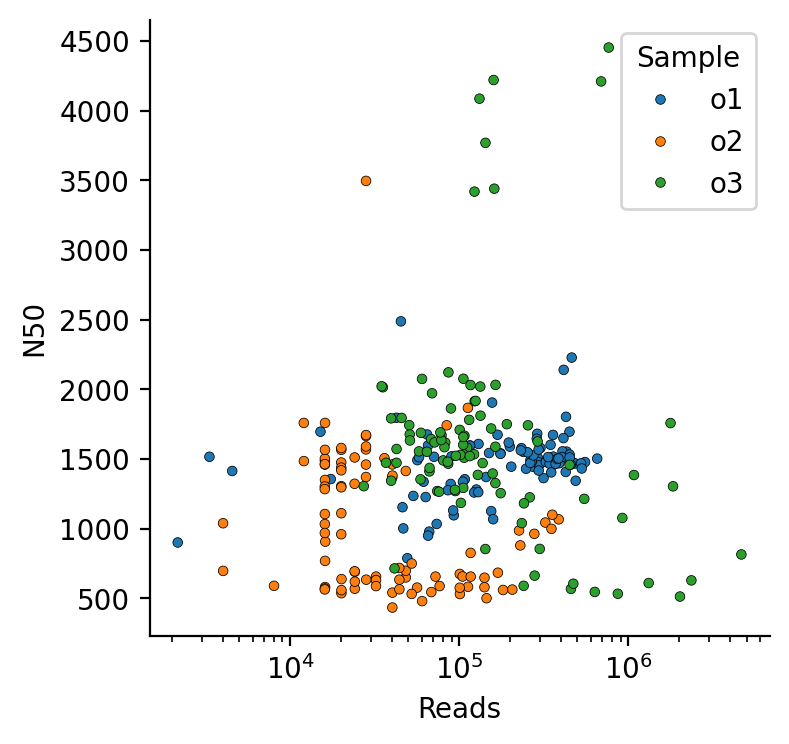

In [26]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=pdf,
                y="N50",
                x='Reads',
                ec='k',
                s=12,
                hue='Sample')

plt.xscale('log')
# plt.yscale('log')
ax = plt.gca()
sns.despine()
plt.show()

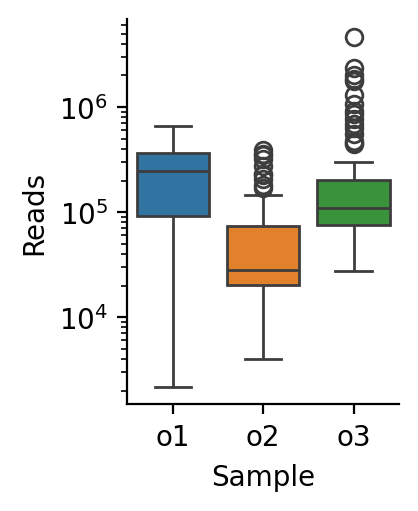

In [34]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.75, 2.5

sns.boxplot(data=pdf,
            y="Reads",
            x='Sample',
            hue='Sample')

plt.yscale('log')

ax = plt.gca()
sns.despine()
plt.show()

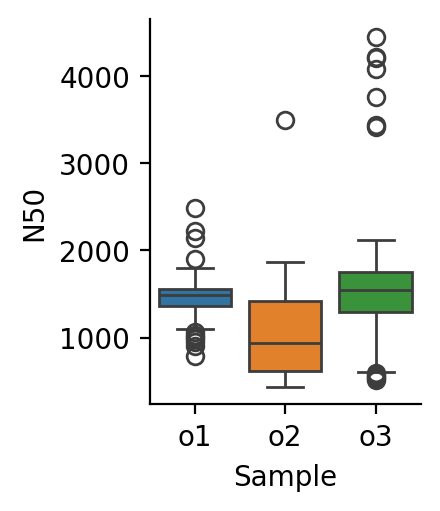

In [35]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.75, 2.5

sns.boxplot(data=pdf,
            y="N50",
            x='Sample',
            hue='Sample')

ax = plt.gca()
sns.despine()
plt.show()

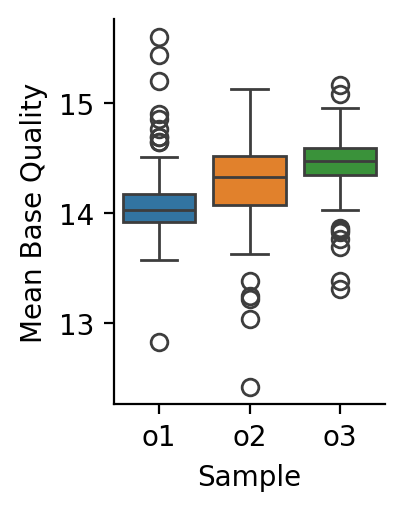

In [37]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.75, 2.5

sns.boxplot(data=pdf,
            y="Mean Base Quality",
            x='Sample',
            hue='Sample')


ax = plt.gca()
sns.despine()
plt.show()